In [1]:
import deepchem as dc
import pandas as pd
import numpy as np
import csv

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern

ModuleNotFoundError: No module named 'deepchem'

In [ ]:
#load the dataset (polymer smiles and their specific gravity)

descriptors = ["BCUT2D_LOGPLOW",
"BCUT2D_MRHI",
"Ipc",
"SlogP_VSA4",
"SlogP_VSA6",
]

print("loading the data...")
loader = dc.data.CSVLoader(["density"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors(descriptors = descriptors))
Data = loader.create_dataset('../csv_files/RoomTemp_dens_Dataset.csv')

loading the data...


we see that some specific gravity values are unknonw, the values of these sample are equal to zero!

In [ ]:
#some RDKit descriptors return nan, make these 0
X = np.nan_to_num(Data.X, copy=True, nan=0.0, posinf=0)
#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=X, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["denstiy"])

In [ ]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(Dataset)
print("Data is splitted into: train, valid, test")


Data is splitted into: train, valid, test


In [ ]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

kernel = 1 * RationalQuadratic() + WhiteKernel()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...
model is fitted


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:

#calculate r2 scores
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
train_r2score = model.evaluate(train_dataset, metric)
valid_r2score = model.evaluate(valid_dataset, metric)
test_r2score= model.evaluate(test_dataset, metric)

#make then useable
testr2=list(test_r2score.values())[0]
validr2=list(valid_r2score.values())[0]
trainr2=list(train_r2score.values())[0]

print("training r2-score:",np.mean(trainr2) )
print("valid r2-score:",np.mean(validr2) )
print("test r2-score:",np.mean(testr2) )

training r2-score: 0.9114351664631976
valid r2-score: 0.7279518204508392
test r2-score: 0.7939218390814761


In [ ]:
#calculate RMSE score
from sklearn.metrics import root_mean_squared_error
RMSE_score = root_mean_squared_error(test_dataset.y,predicted)
print('tets set score:',RMSE_score)

tets set score: 133.86098756992263


In [ ]:
#convert tekst to string, so it can be depicted in matplotlib

text = "test r2= "+ str(round(testr2,4))  + " & RMSE= " +str(round(RMSE_score,4))

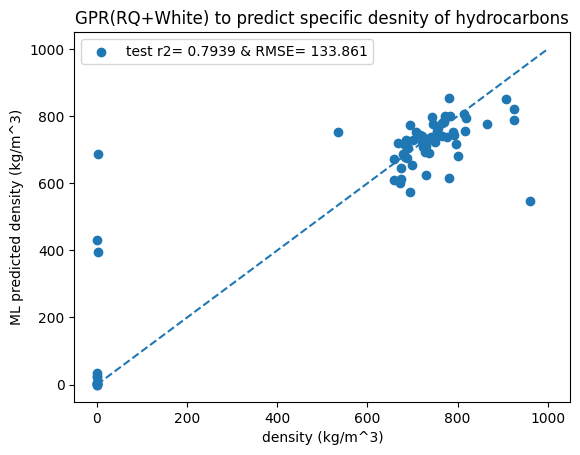

In [ ]:
#plot the data
import matplotlib.pyplot as plt

x=[0,1000]
y=[0,1000]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label=text)
plt.legend()
plt.xlabel("density (kg/m^3)")
plt.ylabel("ML predicted density (kg/m^3)")
plt.title("GPR(RQ+White) to predict specific desnity of hydrocarbons")
plt.show()
